In [1]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import rmsprop_v2
from keras.utils.data_utils import get_file

In [3]:
path = get_file(
    'babi-tasks-v1-2.tar.gz',
    origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)

In [4]:
challenges = {
  # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',   
}

In [5]:
def tokenize(sent):
    '''
    Return the tokens of a sentence including punctuation
     >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the',          'apple', '?']
  
    '''

    return [x.strip() for x in re.split('(\W+)', sent) if x.strip()]

In [6]:
def get_stories(f):
    # data will return a list of triples
    # each triple contains:
    #   1. a story
    #   2. a question about the story
    #   3. the answer to the question
    data = []

    # use this list to keep track of the story so far
    story = []

    # print a random story, helpful to see the data
    printed = False
    for line in f:
        line = line.decode('utf-8').strip()

        # split the line number from the rest of the line
        nid, line = line.split(' ', 1)

        # see if we should begin a new story
        if int(nid) == 1:
            story = []

        # this line contains a question and answer if it has a tab
        #       question<TAB>answer
        # it also tells us which line in the story is relevant to the answer
        # Note: we actually ignore this fact, since the model will learn
        #       which lines are important
        # Note: the max line number is not the number of lines of the story
        #       since lines with questions do not contain any story
        # one story may contain MULTIPLE questions
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)

            # numbering each line is very useful
            # it's the equivalent of adding a unique token to the front
            # of each sentence
            story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]

            # uncomment if you want to see what a story looks like
            # if not printed and np.random.rand() < 0.5:
            #     print("story_so_far:", story_so_far)
            #     printed = True
            data.append((story_so_far, q, a))
            story.append('')
        else:
            # just add the line to the current story
            story.append(tokenize(line))
    return data

In [7]:
# recursively flatten a list
def should_flatten(el):
    return not isinstance(el, (str, bytes))

In [8]:
def flatten(l):
    for el in l:
        # if el is not a string, yield it from flatten
        if should_flatten(el):
            yield from flatten(el)
        else:
            yield el


In [9]:
# convert stories from words into lists of word indexes(integers)
# pad each sequence so that they are the same length
# we will need to re-pad the stories later so that
# each story is the same length

def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([[word2idx[w] for w in s] for s in story])
        queries.append([word2idx[w] for w in query])
        answers.append([word2idx[answer]])

    return (
        [pad_sequences(x, maxlen=story_maxlen) for x in inputs],
        pad_sequences(queries, maxlen=query_maxlen),
        np.array(answers)
    )

In [10]:
# this is like 'pad_sequences' but for entire stories
# we are padding each story with zeros so every story
# has the same number of sentences
# append an array of zeros of size:
# (max_sentences - num sentences in story, max words in sentence)
def stack_inputs(inputs, story_maxsents, story_maxlen):
    for i, story in enumerate(inputs):
        inputs[i] = np.concatenate(
            [
                story,
                np.zeros(
                    (story_maxsents - story.shape[0], story_maxlen),
                    'int'
                )
            ]
        )
    return np.stack(inputs)

In [11]:
# make a function to get the data since
# we want to load both the single supporting fact data
# and the two supporting fact data later

def get_data(challenge_type):
    # input should either be 'single_supporting_fact_10k' or 'two_supporting_facts_10k'
    challenge = challenges[challenge_type]

    # return a list of triplets
    # (story, ques, ans)

    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))

    # group all stories together
    stories = train_stories + test_stories

    # so we can get the max length of each story, of each sentence, and of each question
    story_maxlen = max((len(s) for x, _, _ in stories for s in x))
    story_maxsents = max((len(x) for x, _, _ in stories))
    query_maxlen = max(len(x) for _, x, _ in stories)

    # Create vocabulary of corpus and find size, including a padding element
    vocab = sorted(set(flatten(stories)))
    vocab.insert(0, '<PAD>')
    vocab_size = len(vocab)

    # Create index mapping for the vocab
    word2idx = {c: i for i, c in enumerate(vocab)}

    # convert stories from strings to lists of integers
    input_train, queries_train, answers_train = vectorize_stories(
        train_stories,
        word2idx,
        story_maxlen,
        query_maxlen
    )
    input_test, queries_test, answers_test = vectorize_stories(
        test_stories,
        word2idx,
        story_maxlen,
        query_maxlen
    )

    # convert inputs into 3-D numpy arrays
    inputs_train = stack_inputs(input_train, story_maxsents, story_maxlen)
    inputs_test = stack_inputs(input_test, story_maxsents, story_maxlen)
    print(f'inputs_train.shape : {inputs_train.shape}, inputs_test.shape: {inputs_test.shape}' )

    # return model inputs for keras

    return train_stories, test_stories, \
        inputs_train, queries_train, answers_train, \
        inputs_test, queries_test, answers_test, \
        story_maxsents, story_maxlen, query_maxlen, \
        vocab, vocab_size

In [12]:
# get the single supporting fact data
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('single_supporting_fact_10k')

inputs_train.shape : (10000, 10, 8), inputs_test.shape: (1000, 10, 8)


In [13]:
# CREATE MODEL
embedding_dim = 15

In [17]:
# turn the story into a sequence of embedding vectors
# one for each story line
# treating each story line like a bag of words
input_story_ = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x:K.sum(x, axis=2))(embedded_story)
print(input_story_.shape)
print(embedded_story.shape)

(None, 10, 8)
(None, 10, 15)


In [18]:
# turn the question into an embedding
# also a bag of words
input_question_ = Input((query_maxlen,))
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)

# add a "sequence length" of 1 so that it can
# be dotted with the story later
embedded_question = Reshape((1, embedding_dim))(embedded_question)
print("inp_q.shape, emb_q.shape:", input_question_.shape, embedded_question.shape)

inp_q.shape, emb_q.shape: (None, 4) (None, 1, 15)


In [19]:
# calculate the weights for each story line
# embedded_story.shape        = (N, num sentences, embedding_dim)
# embedded_question.shape     = (N, 1, embedding_dim)
x = dot([embedded_story, embedded_question], 2)
x = Reshape((story_maxsents,))(x)  # flatten the vector
x = Activation('softmax')(x)
story_weights = Reshape((story_maxsents, 1))(
    x)  # unflatten it again to be dotted later
print("story_weights.shape:", story_weights.shape)

story_weights.shape: (None, 10, 1)


In [20]:
x = dot([story_weights, embedded_story], 1)
x = Reshape((embedding_dim,))(x)  # flatten it again
ans = Dense(vocab_size, activation='softmax')(x)

In [24]:
# make the model
model = Model([input_story_, input_question_], ans)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# train the model
r = model.fit(
    [inputs_train, queries_train],
    answers_train,
    epochs=5,
    batch_size=32,
    validation_data=([inputs_test, queries_test], answers_test)
)


Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.5003e-04 - accuracy: 1.0000 - val_loss: 2.5517e-04 - val_accuracy: 1.0000
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.0737e-04 - accuracy: 1.0000 - val_loss: 2.1324e-04 - val_accuracy: 1.0000
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 1.7214e-04 - accuracy: 1.0000 - val_loss: 1.7640e-04 - val_accuracy: 1.0000
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 1.4324e-04 - accuracy: 1.0000 - val_loss: 1.4610e-04 - val_accuracy: 1.0000
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 1.1928e-04 - accuracy: 1.0000 - val_loss: 1.2213e-04 - val_accuracy: 1.0000


In [28]:
# Check how we weight each input sentence given a story and question
debug_model = Model([input_story_, input_question_], story_weights)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debug_model.predict([i, q]).flatten()

In [29]:
story, question, ans = train_stories[story_idx]
print("story:\n")
for i, line in enumerate(story):
    print("{:1.5f}".format(w[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)

story:

0.00001 	 0 Mary moved to the hallway .
0.99997 	 1 John travelled to the hallway .
question: Where is John ?
answer: hallway


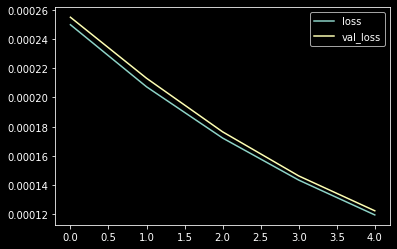

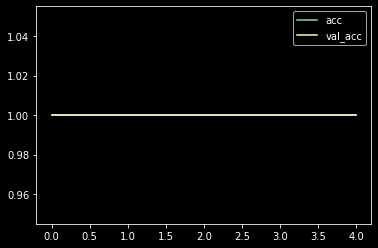

In [30]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [31]:
##### two supporting facts #####


# get the two supporting fact data
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('two_supporting_facts_10k')


##### create the model #####
embedding_dim = 30


# make a function for this so we can use it again
def embed_and_sum(x, axis=2):
    x = Embedding(vocab_size, embedding_dim)(x)
    x = Lambda(lambda x: K.sum(x, axis))(x)
    return x


inputs_train.shape : (10000, 88, 8), inputs_test.shape: (1000, 88, 8)


In [32]:
# define the inputs
input_story_ = Input((story_maxsents, story_maxlen))
input_question_ = Input((query_maxlen,))


# embed the inputs
embedded_story = embed_and_sum(input_story_)
embedded_question = embed_and_sum(input_question_, 1)


# final dense will be used in each hop
dense_layer = Dense(embedding_dim, activation='elu')


In [33]:
# define one hop
# the "query" can be the question, or the answer from the previous hop
def hop(query, story):
    # query.shape = (embedding_dim,)
    # story.shape = (num sentences, embedding_dim)
    x = Reshape((1, embedding_dim))(query)  # make it (1, embedding_dim)
    x = dot([story, x], 2)
    x = Reshape((story_maxsents,))(x)  # flatten it for softmax
    x = Activation('softmax')(x)
    story_weights = Reshape((story_maxsents, 1))(x)  # unflatten for dotting

    # makes a new embedding
    story_embedding2 = embed_and_sum(input_story_)
    x = dot([story_weights, story_embedding2], 1)
    x = Reshape((embedding_dim,))(x)
    x = dense_layer(x)
    return x, story_embedding2, story_weights



In [35]:
# do the hops
ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _,              story_weights2 = hop(ans1,              embedded_story)

# get the final answer
ans = Dense(vocab_size, activation='softmax')(ans2)


# build the model
model2 = Model([input_story_, input_question_], ans)

# compile the model
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [36]:
# fit the model
r = model2.fit(
    [inputs_train, queries_train],
    answers_train,
    epochs=30,
    batch_size=32,
    validation_data=([inputs_test, queries_test], answers_test)
)

Epoch 1/30
313/313 [==============================] - 6s 11ms/step - loss: 2.8245 - accuracy: 0.1458 - val_loss: 1.7957 - val_accuracy: 0.1750
Epoch 2/30
313/313 [==============================] - 3s 8ms/step - loss: 1.8004 - accuracy: 0.1596 - val_loss: 1.7941 - val_accuracy: 0.1870
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 1.8007 - accuracy: 0.1661 - val_loss: 1.7988 - val_accuracy: 0.1590
Epoch 4/30
313/313 [==============================] - 2s 8ms/step - loss: 1.7985 - accuracy: 0.1750 - val_loss: 1.8066 - val_accuracy: 0.1670
Epoch 5/30
313/313 [==============================] - 2s 8ms/step - loss: 1.7980 - accuracy: 0.1754 - val_loss: 1.8078 - val_accuracy: 0.1600
Epoch 6/30
313/313 [==============================] - 2s 8ms/step - loss: 1.7984 - accuracy: 0.1766 - val_loss: 1.7970 - val_accuracy: 0.1870
Epoch 7/30
313/313 [==============================] - 3s 8ms/step - loss: 1.7968 - accuracy: 0.1799 - val_loss: 1.8016 - val_accuracy: 0.1670
Epoch

In [37]:

### print story line weights again ###
debug_model2 = Model(
    [input_story_, input_question_],
    [story_weights1, story_weights2]
)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w1, w2 = debug_model2.predict([i, q])
w1 = w1.flatten()
w2 = w2.flatten()

In [38]:
story, question, ans = train_stories[story_idx]
print("story:\n")
for j, line in enumerate(story):
    print("{:1.5f}".format(w1[j]), "\t",
          "{:1.5f}".format(w2[j]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)
print("prediction:", vocab[np.argmax(model2.predict([i, q])[0])])



story:

0.00000 	 0.05559 	 0 Daniel went to the bedroom .
0.00000 	 0.06008 	 1 Daniel journeyed to the garden .
0.00000 	 0.00065 	 2 John went back to the office .
0.00000 	 0.00080 	 3 John journeyed to the hallway .
0.00000 	 0.00104 	 4 Mary went to the office .
0.00000 	 0.00129 	 5 Mary travelled to the bedroom .
0.00000 	 0.00013 	 6 Daniel got the apple there .
0.00000 	 0.00352 	 7 John moved to the bedroom .
0.00000 	 0.00219 	 8 Sandra moved to the kitchen .
0.00000 	 0.00200 	 9 Daniel discarded the apple .
0.00000 	 0.86211 	 11 Daniel went back to the kitchen .
0.00000 	 0.00281 	 12 Sandra moved to the bathroom .
0.01263 	 0.00020 	 14 Daniel took the football there .
0.00000 	 0.00044 	 15 Daniel grabbed the milk there .
0.00000 	 0.00320 	 17 Sandra journeyed to the office .
0.98736 	 0.00385 	 18 Daniel discarded the football .
question: Where is the football ?
answer: kitchen
prediction: kitchen


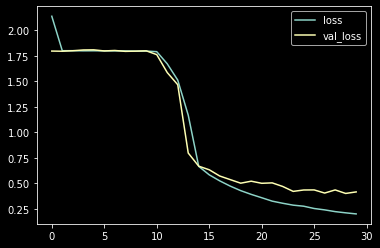

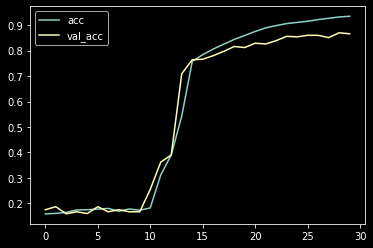

In [39]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
